# LSTM classifier with word embedding representation

In [1]:
# If running on Google Colab, upload the supporting files to google drive
# then run this to import them
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !cp 'drive/My Drive/Colab/__init__.py' .
  !cp 'drive/My Drive/Colab/config.py' .
  !cp 'drive/My Drive/Colab/helper.py' .
  !cp 'drive/My Drive/Colab/train.pickle' .
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
from torch.nn.utils.rnn import (pad_sequence,
                                pack_padded_sequence,
                                pad_packed_sequence)
import torch.nn.functional as F
import spacy
spacy.cli.download('en_core_web_lg')
nlp = spacy.load('en_core_web_lg')
import matplotlib.pyplot as plt

from helper import load_data

assert torch.cuda.is_available(), "Training the model on CPU will take a long time!"
device = torch.device('cuda:0')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [3]:
x_train, x_validation, x_test, y_train, y_validation, y_test = load_data()

N_CLASSES = y_train.columns.size
BATCH_SIZE = 4

In [4]:
def text2tensor(text):
    doc = nlp(text)
    tokens = [token.vector for token in doc if token.is_alpha]
    if len(tokens) < 10:
        tokens = [token.vector for token in doc]
    return torch.Tensor(np.vstack(tokens)).to(device)

In [5]:
def batch_pad_pack_train(corpus, batch_size=64):
    groups = np.arange(len(corpus)) // batch_size
    batched = corpus.groupby(groups)

    tensors = []
    for i, text_batch in batched:
        batched_tensors = [text2tensor(text) for text in text_batch]
        padded = pad_sequence(batched_tensors, batch_first=True)
        packed = pack_padded_sequence(
            padded,
            lengths=[tensor.shape[0] for tensor in batched_tensors],
            batch_first=True,
            enforce_sorted=False)
        tensors.append(packed)

    return tensors

def batch_labels(labels, batch_size=64):
    out = []
    for _, df in labels.groupby(np.arange(len(labels)) // batch_size):
        out.append(torch.Tensor(df.values).to(device))
    return out

In [6]:
x_train_tensors = batch_pad_pack_train(x_train, BATCH_SIZE)
y_train_tensors = batch_labels(y_train, BATCH_SIZE)

x_validation_tensors = batch_pad_pack_train(x_validation, BATCH_SIZE)

In [7]:
class Model(nn.Module):
    EMBEDDING_DIM = 300
    LSTM_HIDDEN_SIZE = 128
    DENSE_SIZE = 32

    def __init__(self, n_classes):
        super(Model, self).__init__()
        self.batchnorm = nn.BatchNorm1d(Model.LSTM_HIDDEN_SIZE)
        self.lstm_1 = nn.LSTM(input_size=Model.EMBEDDING_DIM,
                              hidden_size=Model.LSTM_HIDDEN_SIZE,
                              batch_first=True)
        self.dense_1 = nn.Linear(in_features=Model.LSTM_HIDDEN_SIZE,
                                 out_features=Model.DENSE_SIZE)
        self.dense_2 = nn.Linear(in_features=Model.DENSE_SIZE,
                                 out_features=n_classes)
        self.dropout = nn.Dropout()
    
    def forward(self, embeddings):
        lstm_1_out_packed, _ = self.lstm_1(embeddings)

        # Get last output from a padded sequence of outputs
        lstm_padded, seq_lens = pad_packed_sequence(lstm_1_out_packed, batch_first=True)
        lstm_last_out = lstm_padded[range(lstm_padded.shape[0]), seq_lens - 1, :]

        dense_out_1 = self.dense_1(lstm_last_out)
        dense_out_2 = self.dense_2(self.dropout(dense_out_1))
        return torch.sigmoid(dense_out_2)

In [8]:
def inference_score(model, x, y, average='macro'):
    """
    @param x - list of PyTorch's PackedSequence
    @param y - numpy ndarray (n_samples, n_classes)
    @return ROC AUC score
    """
    batch_size = x[0].sorted_indices.shape[0]
    y_pred = torch.zeros(y.shape, dtype=torch.float32, device=device)
    with torch.no_grad():
        for i, batch in enumerate(x):
            pred_i = model(batch)
            y_pred[i * batch_size : i * batch_size + pred_i.shape[0]] = pred_i

    return roc_auc_score(y, y_pred.cpu(), average=average)

In [9]:
N_EPOCHS = 10
model = Model(N_CLASSES).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

training_scores = []
validation_scores = []

for epoch in range(N_EPOCHS):
    epoch_loss = 0.0
    for text_embedding, ground_truth in zip(x_train_tensors, y_train_tensors):
        optimizer.zero_grad()
        output = model(text_embedding)
        loss = criterion(output, ground_truth)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_score = inference_score(model, x_train_tensors, y_train)
    validation_score = inference_score(model, x_validation_tensors, y_validation)
    print('Epoch [{}/{}] | loss: {:.5f}'.format(
          epoch + 1, N_EPOCHS,
          epoch_loss / len(x_train_tensors)))
    print('ROC AUC score - train: {:.5f}, validation: {:.5f}\n'.format(
          train_score, validation_score))
    training_scores.append(train_score)
    validation_scores.append(validation_score)

Epoch [1/10] | loss: 0.27145
ROC AUC score - train: 0.93174, validation: 0.91887

Epoch [2/10] | loss: 0.23962
ROC AUC score - train: 0.91598, validation: 0.89971

Epoch [3/10] | loss: 0.21305
ROC AUC score - train: 0.94776, validation: 0.93400

Epoch [4/10] | loss: 0.17484
ROC AUC score - train: 0.96808, validation: 0.95359

Epoch [5/10] | loss: 0.15345
ROC AUC score - train: 0.96889, validation: 0.95380

Epoch [6/10] | loss: 0.14455
ROC AUC score - train: 0.98199, validation: 0.96491

Epoch [7/10] | loss: 0.12920
ROC AUC score - train: 0.98609, validation: 0.96551

Epoch [8/10] | loss: 0.11399
ROC AUC score - train: 0.98771, validation: 0.96779

Epoch [9/10] | loss: 0.10924
ROC AUC score - train: 0.98961, validation: 0.96835

Epoch [10/10] | loss: 0.09667
ROC AUC score - train: 0.99309, validation: 0.96952



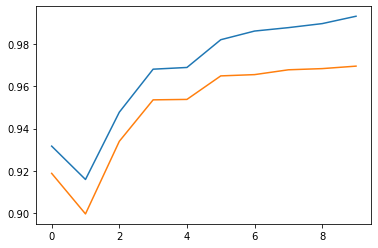

In [10]:
plt.plot(range(len(training_scores)), training_scores)
plt.plot(range(len(validation_scores)), validation_scores)

## Model performance evaluation

In [11]:
x_test_tensors = batch_pad_pack_train(x_test, BATCH_SIZE)

In [12]:
inference_score(model, x_test_tensors, y_test)

0.9686351828184718